# Compression Example
This notebook gives an example of how to use the compression algorithm.

In [2]:
import numpy as np
import time
import xarray as xr
import pickle
import subprocess
import os
import zfpy
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon
from lossycomp.constants import data_path

## Reading Data

In [3]:
data_or = xr.open_mfdataset(data_path + '/data/ECMWF/1980/*/temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-12-1T00:00:00','1980-12-3T1:00:00'), level = slice(985,1000), longitude = slice(-100,-40), latitude = slice(30,-30))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')

## Adding land sea mask

In [4]:
data_soil = xr.open_mfdataset(data_path + '/data/ECMWF/1980_single/*/land-sea-mask.nc', combine='by_coords')
data_soil = data_soil.sel(time=slice('1980-12-1T00:00:00','1980-12-3T1:00:00'),longitude = slice(-100,-40), latitude = slice(30,-30))
data_soil = data_soil.transpose('time', 'latitude', 'longitude')
data_soil = data_soil['lsm']
data_soil = np.expand_dims(data_soil.values, axis=3)
data_or =  np.concatenate((data_or['t'].values, data_soil ),axis = 3)

## Data visualization

(1, 50, 241, 241, 1)


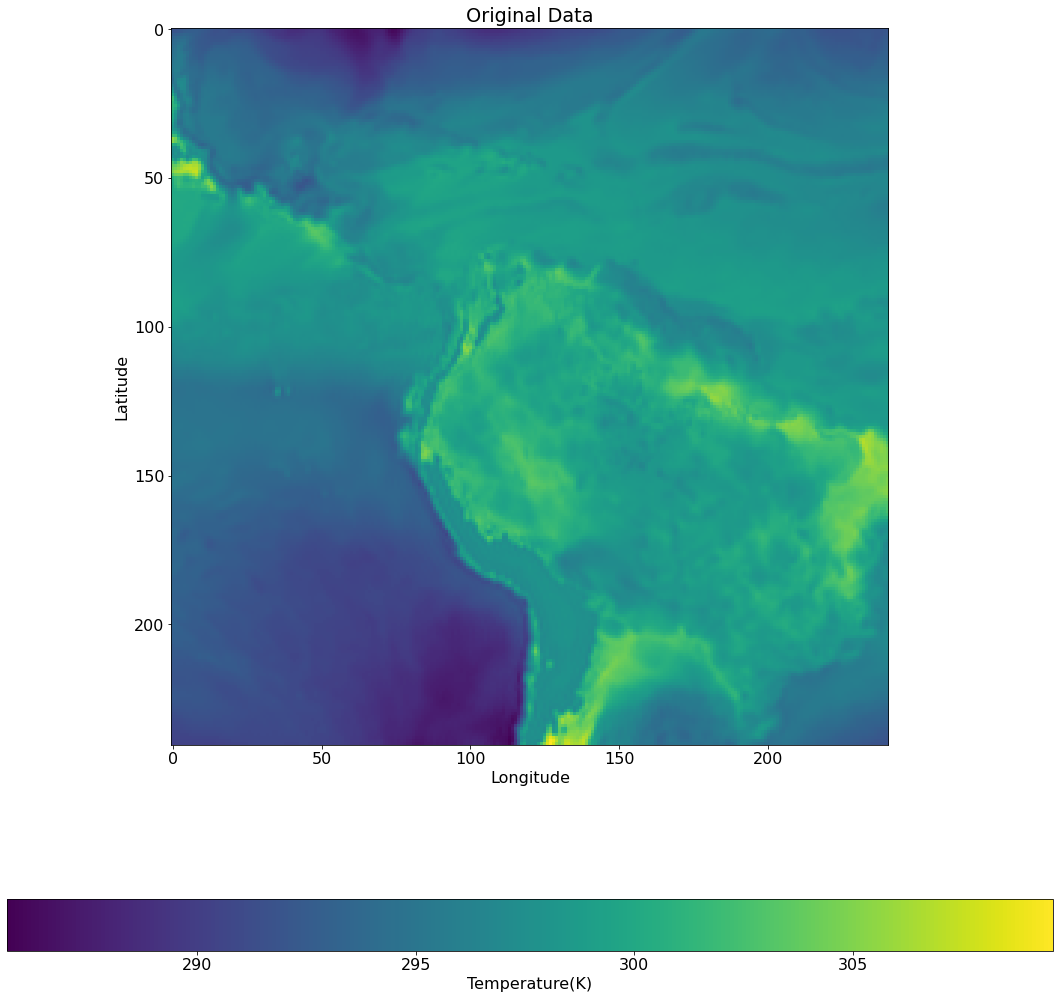

In [5]:
data_r = np.expand_dims(data_or[:,:,:,0], axis=0)
#data_r = np.expand_dims(data_or, axis=0)
data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
plt.rcParams.update({'font.size': 16})
single_plot(data_r, 0, "Original Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

# Compress and Decompress

In [6]:
abs_error = 0.6
#Compress
compressed_data = compress(data_or, abs_error)
# Decompress
decompressed_data = decompress(compressed_data)
CF_model = data_or[:,:,:,0].nbytes / len(compressed_data) 
print('CF:', CF_model)

CF: 38.271108709690175


# Residuals

In [7]:
def psnr(y,x):
    vrange = np.max(y) - np.min(y)
    mse = (np.mean((y-x)*(y-x)))
    psnr = 20 * np.log10(vrange )- 10 * np.log10(mse)
    return psnr

psnr_model = psnr(data_or[0,:,:,0],decompressed_data[0,:,:,0])
error_model = np.max(data_or[:,:,:,:]-decompressed_data[:,:,:,:])
print('PSNR', psnr_model)
print('Max error Model:', np.round(error_model,4))

PSNR 38.96174669265747
Max error Model: 0.6


## Reconstructed data

(1, 50, 241, 241, 1)


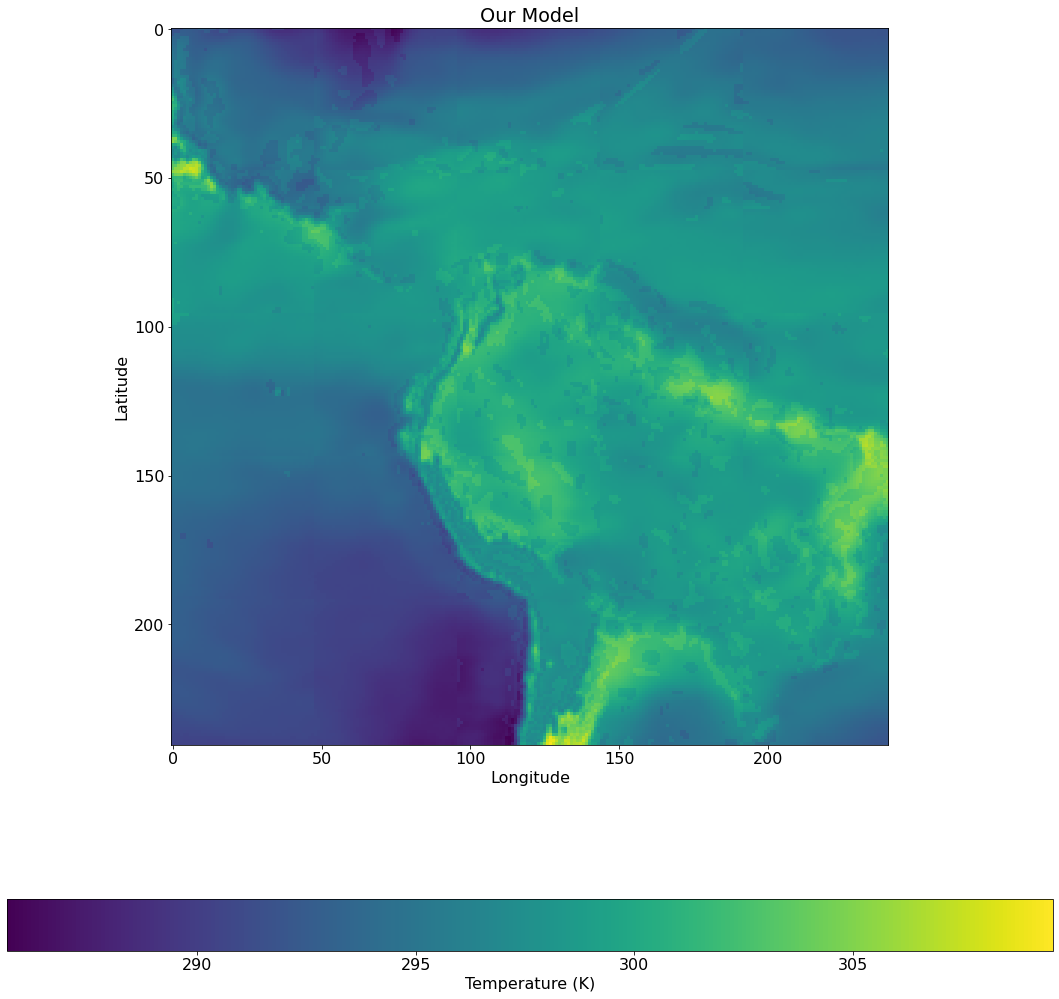

In [8]:
decom = np.expand_dims(decompressed_data, axis=0)
print(decom.shape)
single_plot(decom, 0, "Our Model", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())


Data Original
Mean: 296.3816
Standard Dev.: 3.6194
Max Val: 314.016
Min Val: 281.0232

Decompressed
Mean: 296.3851
Standard Dev.: 3.6211
Max Val: 313.9508
Min Val: 280.6252

Error
Mean: -0.0034
Standard Dev.: 0.2664
Max error: 0.6
Min error: -0.6



Text(0, 0.5, 'Count')

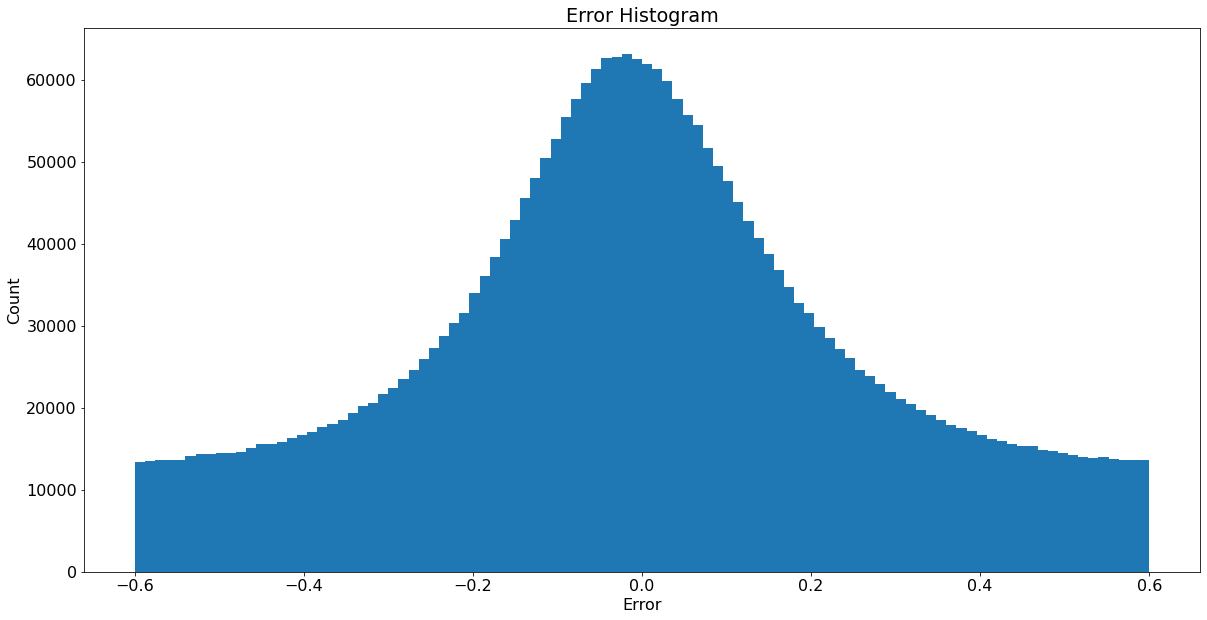

In [9]:
original = data_r
diff = (data_r[0,:,:,:,0]-decompressed_data[:,:,:,0])

print("")
print("Data Original")
print("=======")
print("Mean:", np.round(original.mean(),4))
print("Standard Dev.:", np.round(original.std(),4))
print("Max Val:", np.round(original.max(),4))
print("Min Val:", np.round(original.min(),4))
print("")
print("Decompressed")
print("=======")
print("Mean:", np.round(decompressed_data[:,:,:,0].mean(),4))
print("Standard Dev.:", np.round(decompressed_data[:,:,:,0].std(),4))
print("Max Val:", np.round(decompressed_data[:,:,:,0].max(),4))
print("Min Val:", np.round(decompressed_data[:,:,:,0].min(),4))
print("")
print("Error")
print("=======")
print("Mean:", np.round(diff.mean(),4))
print("Standard Dev.:", np.round(diff.std(),4))
print("Max error:", np.round(diff.max(),4))
print("Min error:", np.round(diff.min(),4))
print("")


plt.figure(figsize=(20,10))
plt.hist(diff.flatten(),100)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

## Residuals

(1, 50, 241, 241, 1)


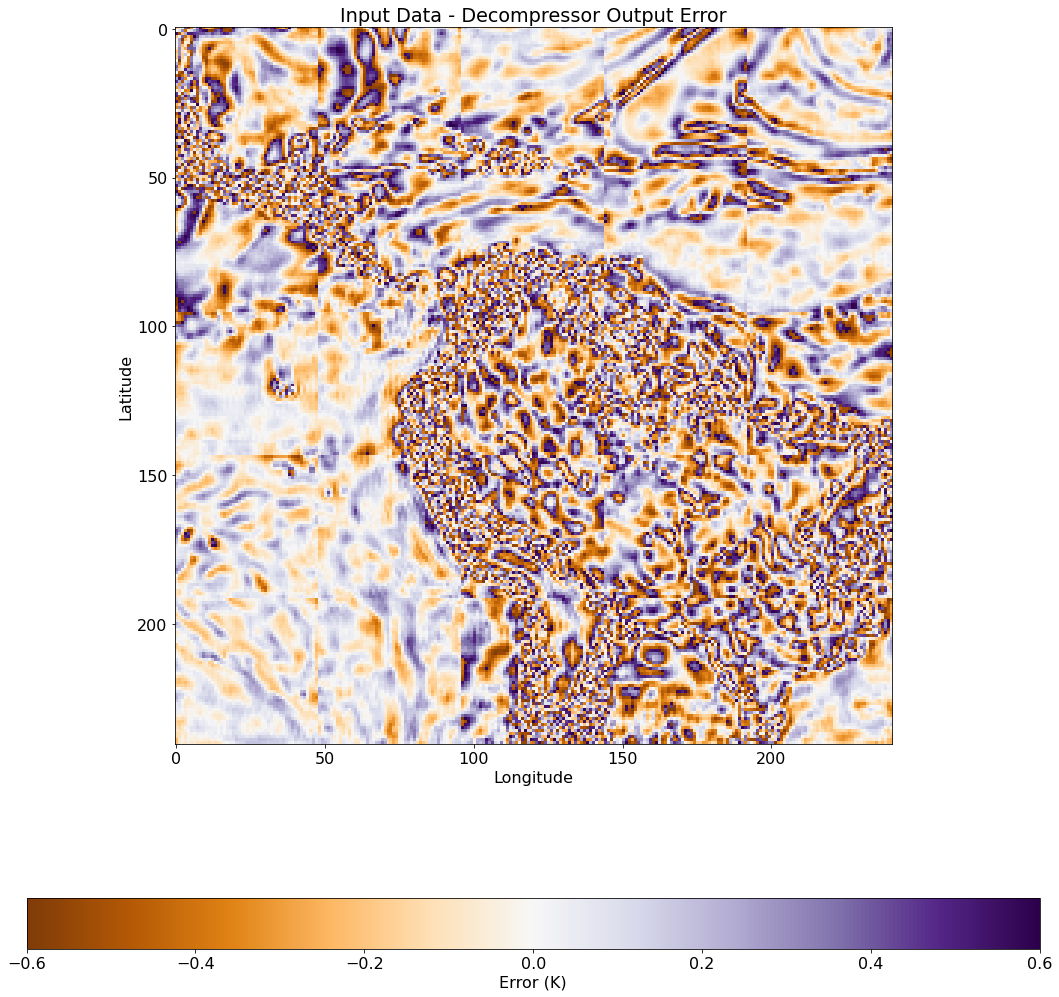

In [10]:
diff = (data_r[0,:,:,:,0]-decompressed_data[:,:,:,0])
diff = np.expand_dims(diff, axis=0)
diff = np.expand_dims(diff, axis=4)
print(diff.shape)
# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

single_plot(diff,0,  "Input Data - Decompressor Output Error", "Error (K)", diff.min(), diff.max(), cmap=cmap)